In [1]:
# !pip install yfinance
#! pip install pandas-datareader -q

In [2]:
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess 
from gensim.models.coherencemodel import CoherenceModel 
from gensim.models.ldamodel import LdaModel
import spacy
import nltk
import pyLDAvis 
import warnings
import pickle
import json
from gensim.models import TfidfModel
import matplotlib.pyplot as plt
import re
from pprint import pprint
import pandas as pd
import time
from gensim.test.utils import datapath
from gensim import corpora, models, similarities
from datetime import datetime
import yfinance as yf
import pandas_datareader as pdr
import requests


warnings.filterwarnings("ignore")

In [3]:
def get_fred_data(param_list, start_date, end_date):
    df = pdr.DataReader(param_list, 'fred', start_date, end_date)
    return df
    

In [4]:
df = pd.read_pickle('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/Replication_Data/cleaned_WSJ_data_V2.pkl')
df_id = pd.read_pickle('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/Replication_Data/WSJ_id2word_V2.pkl')

In [5]:
lda_model = models.LdaModel.load('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/models/50_model_slow_V5.model')

lda_model

In [6]:
# print the most frequent words in each topic
#from pprint import pprint
#pprint(lda_model_190.print_topics())

#### Aggregate attention time series by day

In [7]:
topic_weights = []
dates = []
years = [i for i in range(2006, 2018)]
months = [i for i in range(1,13)]
days = [i for i in range(1,33)]
tops = len(lda_model.get_topics())
corpus = df['corpus'].tolist()


c = 0
l = 365 * 12
#loop thru each month and year
for y in years:
    for m in months:
        for d in days:
            #check if this is a weekend
            try:
                if datetime(y, m, d).weekday() > 4:
                    #print('weekend',y,m,d)
                    c+=1
                    continue
            except:
                #print('invalid', y,m,d)
                c+=1
                continue
            
            #count the documents in teh current day and accumulate the predicted weight of each topic within the documents
            doc_count = 0
            acc_weight = np.zeros(tops)
            temp_df = df.loc[(df['year'] == y) & (df['month'] == m) & (df['day'] == d), ['title']]
            #print(y,m,d,temp_df)
            
            for index, row in temp_df.iterrows():
                new_weight = lda_model[corpus[index]]
                for weight in new_weight:
                    acc_weight[weight[0]] += weight[1]
                doc_count += 1
            #find the relative weight of each topic during the day
            if doc_count != 0:
                acc_weight = acc_weight / doc_count
                topic_weights.append(acc_weight)
                
                dd, mm = str(d), str(m)
                if d < 10: dd = '0'+dd
                if m < 10: mm = '0'+mm
                
                dates.append(str(y)+'-'+str(mm)+'-'+str(dd))
            #do not append days which had no documents (holidays)
            else:
                #print('holiday',y,m,d)   
                pass
            c += 1
            if c % 200 == 0:
                #print(y,m,d)
                print(round(c/l,2) * 100, '%')

9.0 %
14.000000000000002 %
23.0 %
27.0 %
32.0 %
41.0 %
46.0 %
59.0 %
64.0 %
68.0 %
87.0 %
96.0 %
100.0 %


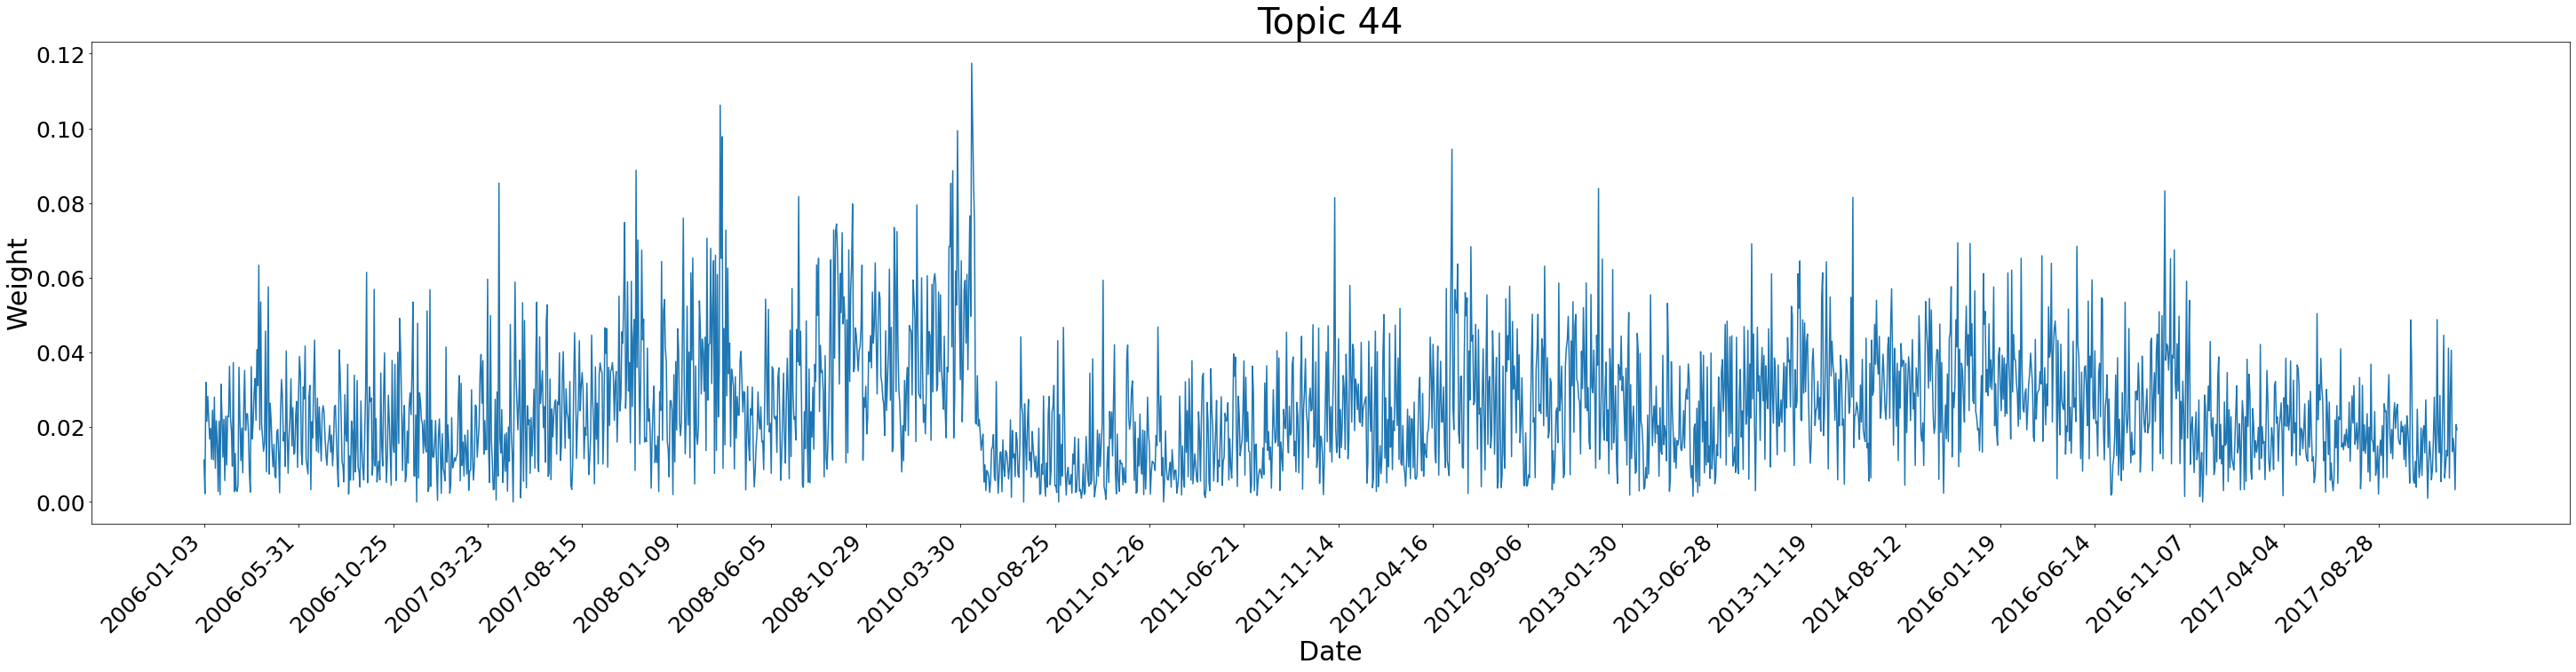

In [15]:
import matplotlib.pyplot as plt

topic_weights = np.array(topic_weights)
dates = np.array(dates)

#plot each of the time-series relative weights of the topics
#again using months so that we can have a representative number of documents while avoiding getting overly granular using daily data
plt.rcParams["figure.figsize"] = (50,10)
for i in range(44, 45): #tops):
    plt.xlabel('Date', fontsize=30)
    plt.ylabel('Weight', fontsize=30)
    plt.title('Topic '+str(i), fontsize=40)
    plt.tick_params(axis='both',labelsize=25)
    plt.xticks(rotation=45, ha='right')
    plt.plot(dates, topic_weights[:,i])
    xticks = plt.gca().xaxis.get_major_ticks()
    for i in range(len(xticks)):
        if i % 100 != 0:
            xticks[i].set_visible(False)
    plt.show()


In [9]:
# Set the start and end date
#start_date = '2006-01-01'
#end_date = '2018-01-01'

# Set the ticker
#ticker = 'DJI'

# Get the data
#ind_data = yf.download(ticker, start_date, end_date)

#ind_data['adj_close_pctchg'] = ind_data['Adj Close'].pct_change().mul(100)
#ind_data['adj_close_pctchg'][0] = 0.0

# Print 5 rows
#ind_data.head(10)

In [10]:
series = 'VIXCLS'
#series = 'SP500'

fred_data = get_fred_data(param_list=[series], start_date='2006-01-01', end_date='2017-12-31')

fred_data['VIXCLS'][0] = 0.0

ind_data = fred_data

#fred_data.head(30)

In [11]:
index_growth = np.array(ind_data['VIXCLS'].tolist())
ind_dates = ind_data.index.tolist()
#print(ind_dates)
ind_dates = [date_obj.strftime('%Y%m%d') for date_obj in ind_dates]

print(ind_dates[0])
print(dates[0].replace('-',''))

print("------------")
inds = []
for i in range(0, len(dates)):  #date in dates:
    if dates[i].replace('-','') not in ind_dates:
        print(dates[i])
        inds.append(i)
        #dates.remove(dates[i])
        #inds.pop(i)

dates_clean = [i for j, i in enumerate(dates) if j not in inds]        
rebuild_weights = [i for j, i in enumerate(topic_weights) if j not in inds]

#print(ind_dates[0][0:4]+'-'+ind_dates[0][4:6]+'-'+ind_dates[0][6:])
#rebuild_dates = []
#rebuild_weights = []

print('----------')
c = 0
for i in range(0, len(ind_dates)): #ind_d in ind_dates:
    if ind_dates[i][0:4]+'-'+ind_dates[i][4:6]+'-'+ind_dates[i][6:] not in dates:
        #print(ind_d[0:4]+'-'+ind_d[4:6]+'-'+ind_d[6:])
        #rebuild_dates.append(ind_d[0:4]+'-'+ind_d[4:6]+'-'+ind_d[6:])
        #rebuild_weights.append([0]*190)
        ind_data.drop(index=ind_dates[i][0:4]+'-'+ind_dates[i][4:6]+'-'+ind_dates[i][6:], inplace = True)
    else:
        #rebuild_dates.append(dates[c])
        #rebuild_weights.append(topic_weights[c])
               
        c += 1

        
print(len(dates_clean))
print(len(ind_data))


20060102
20060103
------------
----------
2384
2384


In [12]:
vixcls = np.array(ind_data['VIXCLS'].tolist())
dates_1 = np.array(dates_clean)

rebuild_weights = pd.DataFrame(rebuild_weights)
rebuild_weights['VIXCLS'] = vixcls
rebuild_weights['date'] = dates_1

raw_attn = rebuild_weights
rebuild_weights

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,VIXCLS,date
0,0.015263,0.002286,0.008343,0.024026,0.030089,0.095607,0.026180,0.026697,0.006870,0.033492,...,0.014383,0.023817,0.011214,0.029390,0.037207,0.015730,0.011882,0.010073,11.14,2006-01-03
1,0.005701,0.010003,0.068963,0.038479,0.017532,0.043863,0.001928,0.051542,0.013177,0.018249,...,0.049555,0.018484,0.002212,0.016073,0.057131,0.011338,0.004055,0.015801,11.37,2006-01-04
2,0.001188,0.000807,0.045246,0.019182,0.015344,0.025954,0.021061,0.032146,0.044511,0.019269,...,0.022366,0.018959,0.032032,0.013900,0.053009,0.014076,0.005819,0.016210,11.31,2006-01-05
3,0.001268,0.003419,0.028945,0.019194,0.012749,0.013175,0.010594,0.037429,0.050696,0.001409,...,0.040304,0.013961,0.021571,0.018422,0.023788,0.005706,0.005978,0.011806,11.00,2006-01-06
4,0.006412,0.001693,0.018334,0.023342,0.058875,0.035447,0.001918,0.049902,0.016807,0.025365,...,0.002386,0.032325,0.028272,0.012542,0.072047,0.010764,0.001623,0.003824,11.13,2006-01-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2379,0.003387,0.013438,0.011659,0.031419,0.016716,0.003357,0.019077,0.025570,0.022723,0.009334,...,0.010910,0.011039,0.017023,0.000563,0.048141,0.003148,0.018099,0.041149,9.90,2017-12-22
2380,0.002098,0.002204,0.017460,0.023005,0.015565,0.002438,0.012845,0.064984,0.013459,0.005790,...,0.005479,0.029505,0.013900,0.001282,0.054658,0.002963,0.006451,0.026321,10.25,2017-12-26
2381,0.001116,0.013284,0.011363,0.036698,0.038446,0.009919,0.015701,0.069143,0.040262,0.028407,...,0.019567,0.009034,0.003264,0.012137,0.062357,0.011546,0.011233,0.020752,10.47,2017-12-27
2382,0.000000,0.010563,0.008319,0.018517,0.029135,0.006431,0.033829,0.061204,0.028558,0.026954,...,0.030333,0.021620,0.020676,0.001910,0.060012,0.003918,0.012575,0.041828,10.18,2017-12-28


In [13]:
raw_attn.to_csv('C:/Users/senic/OneDrive/Desktop/Masters/WINTER_2021/ECO2460/Term_Paper/Code/Replication_Data/var_input_raw_att_50_V5.csv')